<center>

![logo.png](../images/competition_logo_catboost.png)
</center>

<center>

# ⚡️🏁 Baseline - строим базовое решение
</center>

<div class="alert alert-info">
Как решать Kaggle-соревнования? 🏆

Когда мы заходим на соревнование, тем более если оно у вас первым - бежим строить `Baseline`!

`Baseline` - минимально рабочий код, который выдает какой-то результат. По мере соревнования вы его улучшаете => получаете профит 😼

# Настраиваемся на работу 🛠

## Устанавливаем библиотеки 👨‍💻

In [1]:
%%capture

%pip install pandas
%pip install scikit-learn
%pip install seaborn
%pip install catboost

## Импортируем 📦

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import re

from pathlib import Path
from tqdm.auto import tqdm
from sklearn.model_selection import KFold
from catboost import CatBoostRegressor
from sklearn.metrics import root_mean_squared_error


sns.set_theme()
tqdm.pandas()

/nix/store/yd5z6lnhsjim5ik01zbjaijnagi2mn5d-python3.11-tqdm-4.66.2/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Поглядим на данные! 🤹‍♀️

<div class="alert alert-success">

Как настроились на работу - разминаемся на данных! Посмотрим, что нам подсунили организаторы соревнования

In [3]:
home_dir = Path('data/')

train_df = pd.read_csv(str(home_dir / "train.csv")).drop(columns='id')
test_df = pd.read_csv(str(home_dir / "test.csv")).drop(columns='id')
sample_df = pd.read_csv(str(home_dir / "sample_submission.csv"))

FileNotFoundError: [Errno 2] No such file or directory: 'data/train.csv'

## Pandas-методы 🐼

In [ ]:
train_df.head()

,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
0,MINI,Cooper S Base,2007,213000,Gasoline,172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel,A/T,Yellow,Gray,None reported,Yes,4200
1,Lincoln,LS V8,2002,143250,Gasoline,252.0HP 3.9L 8 Cylinder Engine Gasoline Fuel,A/T,Silver,Beige,At least 1 accident or damage reported,Yes,4999
2,Chevrolet,Silverado 2500 LT,2002,136731,E85 Flex Fuel,320.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...,A/T,Blue,Gray,None reported,Yes,13900
3,Genesis,G90 5.0 Ultimate,2017,19500,Gasoline,420.0HP 5.0L 8 Cylinder Engine Gasoline Fuel,Transmission w/Dual Shift Mode,Black,Black,None reported,Yes,45000
4,Mercedes-Benz,Metris Base,2021,7388,Gasoline,208.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,7-Speed A/T,Black,Beige,None reported,Yes,97500


<div class="alert alert-info">

Описание фичей:
* `Brand & Model`: Identify the brand or company name along with the specific model of each vehicle.
* `Model Year`: Discover the manufacturing year of the vehicles, crucial for assessing depreciation and technology advancements.
* `Mileage`: Obtain the mileage of each vehicle, a key indicator of wear and tear and potential maintenance requirements.
* `Fuel Type`: Learn about the type of fuel the vehicles run on, whether it's gasoline, diesel, electric, or hybrid.
* `Engine Type`: Understand the engine specifications, shedding light on performance and efficiency.
* `Transmission`: Determine the transmission type, whether automatic, manual, or another variant.
* `Exterior & Interior Colors`: Explore the aesthetic aspects of the vehicles, including exterior and interior color options.
* `Accident History`: Discover whether a vehicle has a prior history of accidents or damage, crucial for informed decision-making.
* `Clean Title`: Evaluate the availability of a clean title, which can impact the vehicle's resale value and legal status.
* `Price`: Access the listed prices for each vehicle, aiding in price comparison and budgeting.


In [ ]:
train_df['brand'].value_counts()

brand
Ford             23088
Mercedes-Benz    19172
BMW              17028
Chevrolet        16335
Audi             10887
Porsche          10612
Land              9525
Toyota            8850
Lexus             8643
Jeep              6474
Cadillac          4674
RAM               4249
Nissan            3930
Tesla             3738
INFINITI          3276
GMC               3215
Dodge             3133
Mazda             2719
Kia               2497
Lincoln           2423
Subaru            2381
Acura             2282
Honda             2101
Hyundai           2045
Volkswagen        1765
Jaguar            1319
Bentley           1155
MINI              1064
Genesis            969
Buick              940
Maserati           939
Lamborghini        809
Chrysler           727
Volvo              723
Alfa               682
Rivian             590
Rolls-Royce        561
Mitsubishi         551
Pontiac            538
Hummer             520
Ferrari            359
McLaren            243
Aston              238
Satur

<Axes: >

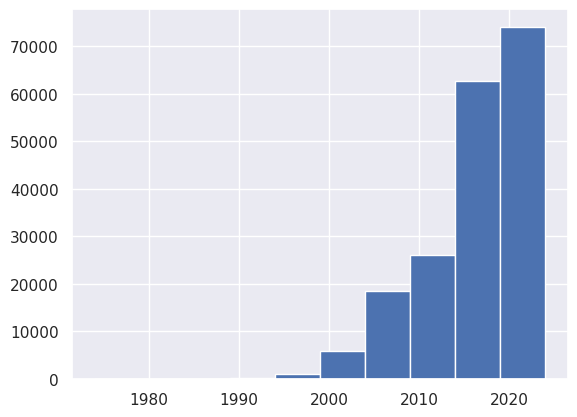

In [ ]:
train_df['model_year'].hist()

In [ ]:
train_df['ext_col'].value_counts()

ext_col
Black                                 48658
White                                 43815
Gray                                  25293
Silver                                16995
Blue                                  14555
                                      ...  
GT SILVER                                 5
Blue Caelum                               5
Granite Crystal Metallic Clearcoat        5
BLUE                                      3
Mango Tango Pearlcoat                     2
Name: count, Length: 319, dtype: int64

In [8]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188533 entries, 0 to 188532
Data columns (total 12 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   brand         188533 non-null  object
 1   model         188533 non-null  object
 2   model_year    188533 non-null  int64 
 3   milage        188533 non-null  int64 
 4   fuel_type     183450 non-null  object
 5   engine        188533 non-null  object
 6   transmission  188533 non-null  object
 7   ext_col       188533 non-null  object
 8   int_col       188533 non-null  object
 9   accident      186081 non-null  object
 10  clean_title   167114 non-null  object
 11  price         188533 non-null  int64 
dtypes: int64(3), object(9)
memory usage: 17.3+ MB


In [9]:
train_df.isna().sum()

brand               0
model               0
model_year          0
milage              0
fuel_type        5083
engine              0
transmission        0
ext_col             0
int_col             0
accident         2452
clean_title     21419
price               0
dtype: int64

<div class="alert alert-info">

Сразу же можем сделать ряд замечаний:
* Задача регрессии и таргет - `price`
* Большинство признаков - `str`. Значит придется предпринять целый ряд действий, чтобы модели из `Sklearn` их съели - LLM? 🥸

# Как генерировать идеи?!💡

<div class="alert alert-success">

Посмотрев на данные - мы должны задать вопрос сами себе:
> Как я могу преобразовать данные и чтобы это дало импакт?

За 10 минут мини-brainstorm получаем список работ на ближайшее время 🤗  
Думайте сами! Мой план работ в [тг-канале 🚀](https://t.me/catboost_agents)

Сегодня только попробуем самые очевидные идеи, чтобы побыстрее перейти к самому вкусному - ML

# Data Engineering 🪖

<div class="alert alert-block alert-info">

Ранее уже сказали, что придется повозиться с признаками, чтобы классические модели ML смогли с ними справиться  
Так как мы делаем `Baseline`, то наша задача побыстрее дойти до результата и главное _зафиксировать_ его!  

Поэтому ничего сверхъественного не делаем - только очевидное!

## Возимся с коробкой передач 🎱

In [10]:
def feat_eng(df):
    df['transmission_type'] = 2.0
    df.loc[df.transmission.str.contains('A/T') | df.transmission.str.contains('Automatic') | df.transmission.str.contains('CVT'), 'transmission_type'] = 0.0
    df.loc[df.transmission.str.contains('Transmission Overdrive Switch') | df.transmission.str.contains('Variable') | 
           df.transmission.str.contains('Single-Speed Fixed Gear') | df.transmission.str.contains('8-SPEED AT'), 'transmission_type'] = 0.0
    df.loc[(df.transmission == 'Auto, 6-Spd w/CmdShft'), 'transmission_type'] = 0.0
    df.loc[df.transmission.str.contains('Dual Shift') | df.transmission.str.contains('At/Mt') |
           df.transmission.str.contains('DCT'), 'transmission_type'] = 1.0
    df.loc[df.transmission.str.contains('Dual-Clutch') | df.transmission.str.contains('Manual Modes'), 'transmission_type'] = 1.0
    df.loc[(df.transmission == 'F') | (df.transmission == '–') | (df.transmission == '2') | (df.transmission == '7-Speed') | 
           (df.transmission == 'SCHEDULED FOR OR IN PRODUCTION') | (df.transmission == '6-Speed'), 'transmission_type'] = 1.0

    df['clean_title'] = df['clean_title'].progress_apply(lambda x: 1 if x == 'Yes' else 0).astype('int')

    df['horsepower'] = df['engine'].str.extract(r'(\d+\.?\d*)HP').astype(float)

    premium_models = ['G90 5.0 Ultimate', 'A8 L 3.0T', 'M4 Base']
    df['model_premium'] = df['model'].isin(premium_models).astype(int)

    premium_brands = ['Audi', 'BMW', 'Mercedes-Benz', 'Lexus', 'Porsche', 'Land Rover', 'Jaguar', 'Cadillac', 'Tesla', 'Volvo', 'Infiniti', 'Lincoln', 'Acura', 'Alfa Romeo', 'Genesis', 'Maserati', 'Bentley', 'Ferrari', 'Lamborghini', 'McLaren', 'Rolls-Royce', 'Bugatti', 'Koenigsegg', 'Pagani']
    df['is_premium_brand2'] = df['brand'].progress_apply(lambda x: any(brand in x for brand in premium_brands)).astype(int)

    return df

train_df_transm  = feat_eng(train_df)
test_df_transm   = feat_eng(test_df)

train_df_transm['horsepower'] = train_df_transm['horsepower'].fillna(0)
test_df_transm['horsepower'] = test_df_transm['horsepower'].fillna(0)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 125690/125690 [00:00<00:00, 264442.41it/s]


<div class="alert">

Так как мы еще не знаем, как автоматизировать процесс, то все частые категории переопределим как нам надо  
Но позже научу вас, как делать это с помощью LLM 😎

In [11]:
train_df_transm

,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price,transmission_type,horsepower,model_premium,is_premium_brand2
0,MINI,Cooper S Base,2007,213000,Gasoline,172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel,A/T,Yellow,Gray,None reported,1,4200,0.0,172.0,0,0
1,Lincoln,LS V8,2002,143250,Gasoline,252.0HP 3.9L 8 Cylinder Engine Gasoline Fuel,A/T,Silver,Beige,At least 1 accident or damage reported,1,4999,0.0,252.0,0,1
2,Chevrolet,Silverado 2500 LT,2002,136731,E85 Flex Fuel,320.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...,A/T,Blue,Gray,None reported,1,13900,0.0,320.0,0,0
3,Genesis,G90 5.0 Ultimate,2017,19500,Gasoline,420.0HP 5.0L 8 Cylinder Engine Gasoline Fuel,Transmission w/Dual Shift Mode,Black,Black,None reported,1,45000,1.0,420.0,1,1
4,Mercedes-Benz,Metris Base,2021,7388,Gasoline,208.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,7-Speed A/T,Black,Beige,None reported,1,97500,0.0,208.0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
188528,Cadillac,Escalade ESV Platinum,2017,49000,Gasoline,420.0HP 6.2L 8 Cylinder Engine Gasoline Fuel,Transmission w/Dual Shift Mode,White,Beige,None reported,1,27500,1.0,420.0,0,1
188529,Mercedes-Benz,AMG C 43 AMG C 43 4MATIC,2018,28600,Gasoline,385.0HP 3.0L V6 Cylinder Engine Gasoline Fuel,8-Speed A/T,White,Black,At least 1 accident or damage reported,1,30000,0.0,385.0,0,1
188530,Mercedes-Benz,AMG GLC 63 Base 4MATIC,2021,13650,Gasoline,469.0HP 4.0L 8 Cylinder Engine Gasoline Fuel,7-Speed A/T,White,Black,None reported,1,86900,0.0,469.0,0,1
188531,Audi,S5 3.0T Prestige,2022,13895,Gasoline,3.0L,1-Speed Automatic,Daytona Gray Pearl Effect,Black,None reported,0,84900,0.0,0.0,0,1


# Теперь натравим на данные CatBoost 😼 и будем радоваться жизни

In [25]:
drop_features = ['model', 'engine', 'transmission', 'ext_col', 'int_col', 'accident', 'fuel_type']
cat_features = ['brand', 'model_year', 'model_premium', 'is_premium_brand2', 'clean_title', 'transmission_type']

In [26]:
train_df = train_df_transm.drop(columns=drop_features)
test_df = test_df_transm.drop(columns=drop_features)

In [31]:
train_df[['transmission_type', 'horsepower']] = train_df[['transmission_type', 'horsepower']].astype(int)
test_df[['transmission_type', 'horsepower']] = test_df[['transmission_type', 'horsepower']].astype(int)

In [32]:
X = train_df.drop('price', axis=1)
y = train_df['price']

## Используем кросс-валидацию 🌀

In [33]:
kf = KFold(n_splits=5, shuffle=True, random_state=2024)

<div class="alert">

Метрика в соревновании `RMSE`. Поэтому везде используем только ее!

In [34]:
X

,brand,model_year,milage,clean_title,transmission_type,horsepower,model_premium,is_premium_brand2
0,MINI,2007,213000,1,0,172,0,0
1,Lincoln,2002,143250,1,0,252,0,1
2,Chevrolet,2002,136731,1,0,320,0,0
3,Genesis,2017,19500,1,1,420,1,1
4,Mercedes-Benz,2021,7388,1,0,208,0,1
...,...,...,...,...,...,...,...,...
188528,Cadillac,2017,49000,1,1,420,0,1
188529,Mercedes-Benz,2018,28600,1,0,385,0,1
188530,Mercedes-Benz,2021,13650,1,0,469,0,1
188531,Audi,2022,13895,0,0,0,0,1


In [37]:
model_list = []
scores = []
for train_idx, test_idx in tqdm(kf.split(train_df), total=kf.get_n_splits()):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    model = CatBoostRegressor(
        iterations=5000, # Ставим так много, потому что Early Stopping Rounds позволяет выпендриваться
        verbose=300, # Как часто выводим на экран информацию по обучению
        random_seed=2024, # Фиксируем случайность
        early_stopping_rounds=300, # Если переобучаемся - стоп ⛔️
    )

    model.fit(
        X_train, y_train,
        cat_features=cat_features, # Не забываем про категориальные фичи
        eval_set=(X_test, y_test) # Cross-Validation 😎 
    )

    y_pred = model.predict(X_test)

    score = root_mean_squared_error(y_test, y_pred)
    model_list.append(model)
    scores.append(score)

    print(f"RMSE: {score:.4f}")
print(f'Mean Score: {np.mean(scores) + np.std(scores)}')

  0%|                                                                                                                                                                                                            | 0/5 [00:00<?, ?it/s]

Learning rate set to 0.041932
0:	learn: 77925.8146639	test: 80597.9274201	best: 80597.9274201 (0)	total: 61.5ms	remaining: 5m 7s
300:	learn: 71533.9390629	test: 75428.5925070	best: 75425.3152452 (293)	total: 8.96s	remaining: 2m 19s
Stopped by overfitting detector  (300 iterations wait)

bestTest = 75425.31525
bestIteration = 293

Shrink model to first 294 iterations.


 20%|███████████████████████████████████████▏                                                                                                                                                            | 1/5 [00:18<01:15, 18.76s/it]

RMSE: 75425.3152
Learning rate set to 0.041932
0:	learn: 78201.0780206	test: 79522.1458505	best: 79522.1458505 (0)	total: 62.3ms	remaining: 5m 11s
300:	learn: 72187.0742830	test: 74250.1852812	best: 74248.8642017 (291)	total: 8.17s	remaining: 2m 7s
600:	learn: 71721.5234114	test: 74232.4909038	best: 74229.3550690 (349)	total: 16.9s	remaining: 2m 3s
900:	learn: 71187.9266163	test: 74225.7280683	best: 74201.5849988 (843)	total: 25.7s	remaining: 1m 56s
Stopped by overfitting detector  (300 iterations wait)

bestTest = 74201.585
bestIteration = 843

Shrink model to first 844 iterations.


 40%|██████████████████████████████████████████████████████████████████████████████▍                                                                                                                     | 2/5 [00:52<01:22, 27.34s/it]

RMSE: 74201.5850
Learning rate set to 0.041932
0:	learn: 78640.6291639	test: 77762.7463397	best: 77762.7463397 (0)	total: 42.4ms	remaining: 3m 32s
300:	learn: 72413.6444283	test: 72424.3552065	best: 72424.3552065 (300)	total: 9s	remaining: 2m 20s
600:	learn: 71589.2200802	test: 72415.6944365	best: 72392.0038041 (349)	total: 18.2s	remaining: 2m 13s
Stopped by overfitting detector  (300 iterations wait)

bestTest = 72392.0038
bestIteration = 349

Shrink model to first 350 iterations.


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                              | 3/5 [01:12<00:48, 24.25s/it]

RMSE: 72392.0038
Learning rate set to 0.041932
0:	learn: 77531.8579375	test: 82083.2193992	best: 82083.2193992 (0)	total: 48.5ms	remaining: 4m 2s
300:	learn: 71382.7218634	test: 76879.0046663	best: 76878.0699056 (297)	total: 8.97s	remaining: 2m 20s
600:	learn: 70674.9772274	test: 76870.8892488	best: 76864.8830516 (461)	total: 18.2s	remaining: 2m 13s
Stopped by overfitting detector  (300 iterations wait)

bestTest = 76864.88305
bestIteration = 461

Shrink model to first 462 iterations.


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 4/5 [01:36<00:24, 24.08s/it]

RMSE: 76864.8831
Learning rate set to 0.041932
0:	learn: 80003.5317645	test: 71974.7401094	best: 71974.7401094 (0)	total: 56.8ms	remaining: 4m 43s
300:	learn: 74121.9386551	test: 66037.3686897	best: 66037.3463549 (299)	total: 8.36s	remaining: 2m 10s
600:	learn: 73624.5072025	test: 65953.0644712	best: 65951.0631859 (560)	total: 16.5s	remaining: 2m 1s
900:	learn: 73166.6256012	test: 65916.5069959	best: 65903.9241909 (770)	total: 24.4s	remaining: 1m 51s
Stopped by overfitting detector  (300 iterations wait)

bestTest = 65903.92419
bestIteration = 770

Shrink model to first 771 iterations.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:06<00:00, 25.34s/it]

RMSE: 65903.9242
Mean Score: 76777.96682917122


Обучили модель, а что все это значит? Кросс-валидация дает сразу несколько плюсов:
* Получаем вместо одной модели - пять!
* Можем предположить оценку на лб. Скор у нас ~ Сколько и на сервере
* Хватит подводить итоги - засылаем!


# Засылаем на все бабки 🤑

In [38]:
test_df

,brand,model_year,milage,clean_title,transmission_type,horsepower,model_premium,is_premium_brand2
0,Land,2015,98000,1,0,240,0,0
1,Land,2020,9142,1,0,395,0,0
2,Ford,2022,28121,0,0,0,0,0
3,Audi,2016,61258,0,0,0,0,1
4,Audi,2018,59000,1,0,252,0,1
...,...,...,...,...,...,...,...,...
125685,Mercedes-Benz,2014,83315,1,0,362,0,1
125686,Audi,2019,29336,0,0,0,0,1
125687,Audi,2012,77634,1,0,333,0,1
125688,Audi,2012,112000,1,0,333,0,1


In [41]:
for (test_idx, _), model in tqdm(zip(kf.split(test_df), model_list), total=kf.get_n_splits()):
    X = test_df.iloc[test_idx]
    y_pred = model.predict(X)

    sample_df.loc[test_idx, "price"] = y_pred

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.06it/s]


In [42]:
sample_df

,id,price
0,188533,18602.958146
1,188534,76235.277534
2,188535,52117.036289
3,188536,33191.718483
4,188537,30208.232627
...,...,...
125685,314218,24121.147347
125686,314219,48605.012914
125687,314220,21710.648351
125688,314221,16521.375285


## Чуть-чуть пошаманим 🥁 

In [45]:
sample_df['price'] = np.round(sample_df['price'] / 5) * 5

In [47]:
sample_df.to_csv('./submission/baseline.csv', index=False)

<div class="alert">

76777.96682917122 -> 72706.03725  
На лидерборде получили даже меньше чем ожидали. Приятно!

В итоге 440 место из 800. Практически ничего не делая)

# Итоги 🧐

Сегодня построили свой первый неплохой `Baseline`, который можно расширять и подниматся выше по `liderboard`  
Теперь давайте о плохом, что обязательно надо исправлять:

- Мы никак не использовали ряд признаков: модель, интерьер, цвет кузова и прочее. Что очень плохо, так как мы теряем ценную информацию на пустом месте!
- Модель очень слабая... Хоть и использовали `CatBoost`, он все равно еще в детском садике, так что есть куда расти
- Одна модель всегда плохо. Один `CatBoost` не решит все проблемы человечества, поэтому надо пробовать разные архитектуры и так тоже улучшать скор

Проблемы определили, так что идем их улучшать и подниматься по списку чемпионов! Чтобы следить за соревнованием подписывайтесь на [мой тг-канал - CatBoost Agents 🚀](https://t.me/catboost_agents)